<a href="https://colab.research.google.com/github/prasadanvekar/elvtrdocs/blob/main/Assignment6_Comparativeanalysisoffrauddetectionmodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0  

       distan

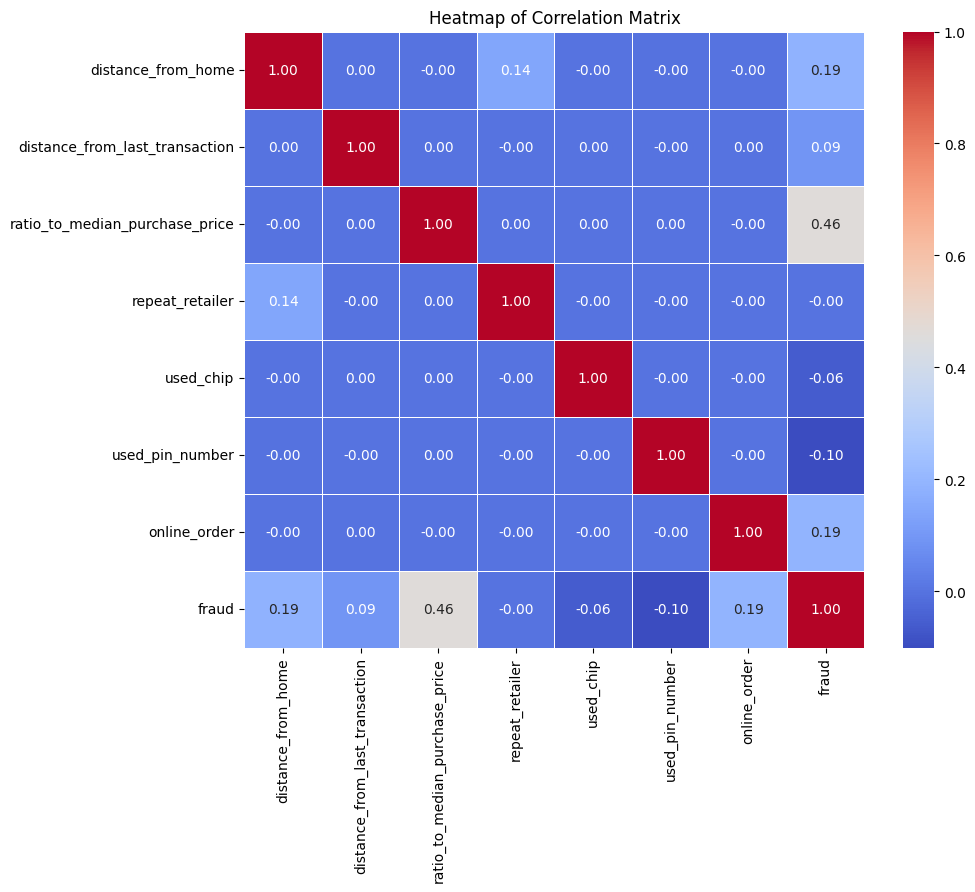

In [ ]:
##############################################################################
# Objective: Comparative Analysis of Fraud Detection Models                  #
# Date: 13 Jan 2024                                                          #
# Author: Prasad S Anvekar                                                   #
##############################################################################
#Data upload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  roc_curve, auc
from sklearn.tree import plot_tree
import seaborn as sns

# Load the dataset
url = 'https://raw.githubusercontent.com/marhcouto/fraud-detection/master/data/card_transdata.csv?raw=true'
data = pd.read_csv(url)

#######################################
#Data exploration section             #
#######################################

# Print the top and bottom 5 rows
print(data.head(5))
print("")

# Section 2: Data Exploration
# Summary statistics
print(data.describe())

# Event rate
event_rate = data['fraud'].mean() * 100
print(f'Event Rate: {event_rate:.2f}%')

# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Analysis specific to the target variable 'default'
missing_values_target = missing_values['fraud']
missing_percentage_target = missing_percentage['fraud']

# Preparing the analysis output for the entire dataset and for the target variable
missing_data_analysis = pd.DataFrame({
    'Feature': data.columns,
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

missing_data_analysis_target = pd.DataFrame({
    'Feature': ['fraud'],
    'Missing Values': [missing_values_target],
    'Percentage (%)': [missing_percentage_target]
})

# To display the analysis results
print("Missing Data Analysis for the Entire Dataset:")
print(missing_data_analysis)
print("\nMissing Data Analysis for the Target Variable 'default':")
print(missing_data_analysis_target)


# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()


# Define the atrributes (X) and the label (y)
X = data.drop('fraud', axis=1)
y = data['fraud']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####################################################################
# Decision Tree Model                                              #
####################################################################
# Define the hyperparameters for the Decision Tree
dt_params = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Create GridSearchCV object with DecisionTreeClassifier
dt = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model on the training set using the scaled features
dt.fit(X_train, y_train)

# Predict on the test set
dt_pred = dt.predict(X_test)

# Calculate the performance metrics
tree_acc = accuracy_score(y_test, dt_pred)  # Changed variable name to 'tree_acc'
tree_recall = recall_score(y_test, dt_pred)  # Changed variable name to 'tree_recall'
tree_precision = precision_score(y_test, dt_pred)  # Changed variable name to 'tree_precision'

# Decision Tree Visualization
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming 'poly' is the PolynomialFeatures instance used for transformation
# and 'dt' is the trained DecisionTreeClassifier within GridSearchCV
feature_names_poly = poly.get_feature_names_out().tolist()  # Convert to list

plt.figure(figsize=(20, 10))
# Using the feature names from PolynomialFeatures for visualization
plot_tree(dt.best_estimator_, filled=True, feature_names=feature_names_poly, class_names=['No Default', 'Default'])
plt.title("Decision Tree Visualization")
plt.show()

# Print the performance metrics
print(f"Decision Tree - Accuracy: {tree_acc:.3f}")
print(f"Decision Tree - Recall: {tree_recall:.3f}")
print(f"Decision Tree - Precision: {tree_precision:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, dt_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# ROC Curve
y_pred_prob = dt.best_estimator_.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right")
plt.show()

# Decision Boundary Analysis
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Train Decision Tree on the first two principal components for visualization
dt_pca = DecisionTreeClassifier(max_depth=dt.best_params_['max_depth'])
dt_pca.fit(X_train_pca, y_train)

# Create a mesh grid on the PCA-reduced 2D space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict on the mesh grid
Z = dt_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Decision Tree Decision Boundary with PCA-reduced Features')
plt.show()

####################################################################
# Random Forest Model                                              #
####################################################################

# Define the hyperparameters for the Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # 'auto' is equivalent to 'sqrt'
}

# Create GridSearchCV object with RandomForestClassifier
rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model on the training set using the scaled features
rf.fit(X_train, y_train)

# Predict on the test set
rf_pred = rf.predict(X_test)

# Calculate the performance metrics
rf_acc = accuracy_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)

# Print the performance metrics
print(f"Random Forest - Accuracy: {rf_acc:.3f}")
print(f"Random Forest - Recall: {rf_recall:.3f}")
print(f"Random Forest - Precision: {rf_precision:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Assuming that poly is the PolynomialFeatures instance fitted on the training data
poly_feature_names = poly.get_feature_names_out()

# Now create the DataFrame using the correct feature names
feature_importances = pd.DataFrame(rf.best_estimator_.feature_importances_,
                                   index=poly_feature_names,  # Updated to use all feature names
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


# ROC Curve
y_pred_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

# Decision Boundary Analysis
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Train Random Forest on the first two principal components for visualization
rf_pca = RandomForestClassifier(n_estimators=100, max_depth=rf.best_params_['max_depth'])
rf_pca.fit(X_train_pca, y_train)

# Create a mesh grid on the PCA-reduced 2D space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict on the mesh grid
Z = rf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Random Forest Decision Boundary with PCA-reduced Features')
plt.show()

################################################################################
# Model Comparison                                                             #
################################################################################

# Section 7: Model Comparison with Visualization
models = [ 'Decision Tree', 'Random Forest']
acc_scores = [ tree_acc, rf_acc]  # Assuming these are correctly calculated
recall_scores = [ tree_recall, rf_recall]
precision_scores = [ tree_precision,  rf_precision]

# Creating a DataFrame for scores
performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': acc_scores,
    'Recall': recall_scores,
    'Precision': precision_scores
})
print(performance_df)

# Plotting ROC Curves for all models
plt.figure(figsize=(10, 8))
for model in [ dt, rf]:
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.best_estimator_.__class__.__name__} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

# Generate and Display Lift Table

def generate_lift_table(y_true, y_pred_prob, deciles=10):
    # Create a DataFrame for calculations
    data = pd.DataFrame({'prob': y_pred_prob, 'actual': y_true})

    # Sort by predicted probabilities in descending order
    data = data.sort_values(by='prob', ascending=False)

    # Assign deciles
    data['decile'] = pd.qcut(data['prob'], q=deciles, labels=np.arange(1, deciles + 1))

    # Calculating necessary statistics per decile
    lift_table = data.groupby('decile').agg(
        obs=('prob', 'count'),
        avg_score=('prob', 'mean'),
        event_rate=('actual', 'mean'),
        actual_events=('actual', 'sum')
    )

    # Calculating cumulative statistics
    lift_table['cum_events'] = lift_table['actual_events'].cumsum()
    lift_table['cum_non_events'] = (lift_table['obs'] - lift_table['actual_events']).cumsum()

    total_events = lift_table['actual_events'].sum()
    total_non_events = data['actual'].count() - total_events

    lift_table['cum_pct_events'] = lift_table['cum_events'] / total_events
    lift_table['cum_pct_non_events'] = lift_table['cum_non_events'] / total_non_events

    # Calculating Lift and KS
    lift_table['lift'] = lift_table['event_rate'] / (total_events / data.shape[0])
    lift_table['KS'] = np.abs(lift_table['cum_pct_events'] - lift_table['cum_pct_non_events'])

    # Resetting index for a better view
    lift_table.reset_index(inplace=True)

    return lift_table

# Generate lift table for the best model (Assuming best_model and y_pred_prob have been identified)
lift_table = generate_lift_table(y_test, y_pred_prob)
print(lift_table)